# 다중 분류 지화 
- 프로젝트에 사용된 파일

In [40]:
# 모듈 로딩
import pandas as pd
import numpy as np

from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt

# 데이터 불러오기

In [41]:
from torchvision.datasets import ImageFolder 

train_root = "./data/asl_dataset" # 해당 경로 내에 있는 파일명이 곧 label이 되는 것

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

preprocessing = transforms.Compose([
    transforms.Resize((100, 100), interpolation=transforms.InterpolationMode.BILINEAR), # 1. resize
    # transforms.CenterCrop(224), # 2. 중앙크롭
    transforms.ToTensor(),  # 3. 값의 크기를 0~1로
    transforms.Normalize(mean=mean, std=std) # 4. normalized
])

imgDS = ImageFolder(root=train_root, transform=preprocessing)

In [42]:
imgDS.samples[-1]

('./data/asl_dataset\\z\\hand5_z_dif_seg_5_cropped.jpeg', 35)

## 데이터 셋이 잘 읽혔는지 확인

In [43]:
class_num = len(imgDS.classes)

print("class 개수 =>",class_num)
print(imgDS.classes)

class 개수 => 36
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [44]:
import pickle

# class_to_idx 딕셔너리를 가져옵니다.
class_to_idx = imgDS.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()} # key value위치 바꿈 

# class_to_idx 딕셔너리를 파일로 저장합니다.
with open('class_to_idx.pickle', 'wb') as handle:
    pickle.dump(idx_to_class, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 저장된 class_to_idx 딕셔너리를 불러옵니다.
with open('class_to_idx.pickle', 'rb') as handle:
    loaded_class_to_idx = pickle.load(handle)

print(loaded_class_to_idx)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'a', 11: 'b', 12: 'c', 13: 'd', 14: 'e', 15: 'f', 16: 'g', 17: 'h', 18: 'i', 19: 'j', 20: 'k', 21: 'l', 22: 'm', 23: 'n', 24: 'o', 25: 'p', 26: 'q', 27: 'r', 28: 's', 29: 't', 30: 'u', 31: 'v', 32: 'w', 33: 'x', 34: 'y', 35: 'z'}


In [45]:
imgDS.classes, imgDS.class_to_idx

(['0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  'a',
  'b',
  'c',
  'd',
  'e',
  'f',
  'g',
  'h',
  'i',
  'j',
  'k',
  'l',
  'm',
  'n',
  'o',
  'p',
  'q',
  'r',
  's',
  't',
  'u',
  'v',
  'w',
  'x',
  'y',
  'z'],
 {'0': 0,
  '1': 1,
  '2': 2,
  '3': 3,
  '4': 4,
  '5': 5,
  '6': 6,
  '7': 7,
  '8': 8,
  '9': 9,
  'a': 10,
  'b': 11,
  'c': 12,
  'd': 13,
  'e': 14,
  'f': 15,
  'g': 16,
  'h': 17,
  'i': 18,
  'j': 19,
  'k': 20,
  'l': 21,
  'm': 22,
  'n': 23,
  'o': 24,
  'p': 25,
  'q': 26,
  'r': 27,
  's': 28,
  't': 29,
  'u': 30,
  'v': 31,
  'w': 32,
  'x': 33,
  'y': 34,
  'z': 35})

In [46]:
from sklearn.model_selection import train_test_split

# 이미지 데이터와 레이블을 가져옴
images = [img for img, _ in imgDS]
labels = [label for _, label in imgDS]

# Stratified sampling을 사용하여 train, validation, test 세트로 분할
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.1, stratify=labels)
# val_images, test_images, val_labels, test_labels = train_test_split(valtest_images, valtest_labels, test_size=0.5, stratify=valtest_labels)

In [47]:
# split 결과 비율 확인 
# print(np.unique(np.array(train_labels),  return_counts=True))
# print(np.unique(np.array(val_labels),  return_counts=True))
# print(np.unique(np.array(test_labels),  return_counts=True))

In [48]:
class CustomDataset(Dataset): 
  def __init__(self, data, label):
      self.data = data
      self.label = torch.LongTensor(label)

  def __len__(self):
      return len(self.data)
  
  def __getitem__(self, idx): 
      x = self.data[idx]
      y = self.label[idx]
      return x, y

In [49]:
len(images), len(val_images)

(2515, 252)

In [50]:
# # 데이터셋 생성
# train_dataset = CustomDataset(images, labels)
val_dataset = CustomDataset(val_images, val_labels)
# # test_dataset = CustomDataset(test_images, test_labels)

# DataLoader 생성
train_loader = DataLoader(imgDS, batch_size=len(images), shuffle=True) #일단 배치없이 가?
val_loader = DataLoader(val_dataset, batch_size=len(val_images), shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=40)

In [51]:
for batch_idx, (data, labels) in enumerate(train_loader):
    print('Batch', batch_idx)
    print('Data shape:', data.shape)
    print('Labels:', torch.bincount(labels))
    print()

Batch 0
Data shape: torch.Size([2515, 3, 100, 100])
Labels: tensor([70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 65, 70, 70, 70, 70, 70, 70])



In [52]:
for batch_idx, (data, labels) in enumerate(val_loader):
    print('Batch', batch_idx)
    print('Data shape:', data.shape)
    print('Labels:', torch.bincount(labels))
    print()

Batch 0
Data shape: torch.Size([252, 3, 100, 100])
Labels: tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])



# 전이학습 VGG model 불러오기

In [53]:
### ===> 딥러닝 모델을 설계할 때 활용하는 장비 확인
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.2.2  Device: cpu


In [54]:
# 사전 학습된 모델 로딩
import torchvision.models as models # 다양한모델패키지
model = models.vgg16(pretrained=True)

# 사전 훈련된 모델의 파라미터 학습 유무 설정 함수
def set_parameter_requires_grad(model, feature_extract = True):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False # 학습하는 것을 방지

set_parameter_requires_grad(model) # 함수 호출

c:\Users\kdp\anaconda3\envs\TORCH_NLP38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kdp\anaconda3\envs\TORCH_NLP38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [55]:
# 분류기 부분을 이진 분류기로 수정하는 클래스 정의
class genreClassifier(nn.Module):
    def __init__(self):
        super(genreClassifier, self).__init__()
        # VGG16의 특성 추출기 부분만 가져오기
        self.features = model.features
        # VGG16의 특성 추출기의 출력 크기 계산
        self.num_features = 512 * 3 * 3  # VGG16은 입력 이미지를 224x224 크기로 처리하므로, 50x50으로 하면 위 공식에 따라 1x1로 출력됩니다.
        
        # 이진 분류를 위한 새로운 fully connected layer 정의
        self.fc = nn.Sequential(
            nn.Linear(self.num_features, 4096),  # 특성 추출기의 출력 크기를 입력으로 받음
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, class_num),  # class_num 클래스 개수를 의미 
            # nn.Sigmoid()  # 이진 분류를 위한 시그모이드 활성화 함수
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return x

# 모델 생성
model = genreClassifier()

# 특성 추출기 부분의 파라미터를 고정시킴
set_parameter_requires_grad(model)

# 모델 구조 확인
print(model)

genreClassifier(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0

In [56]:
for param in model.fc.parameters(): # 완전연결층은학습
    param.requires_grad = True

위 코드에서 BinaryClassifier 클래스는 VGG16의 특성 추출기 부분을 가져와서 이진 분류를 위한 새로운 fully connected layer를 추가하여 이진 분류기로 만듭니다. set_parameter_requires_grad 함수를 사용하여 특성 추출기 부분의 파라미터를 고정시킵니다. 이렇게 하면 특성 추출기 부분은 사전 훈련된 가중치를 고정시키고, 분류기 부분만 새로 훈련됩니다.

In [57]:
# model.__dict__

In [58]:

#################
optimizer = torch.optim.Adam(model.fc.parameters()) # fc인 것이 중요!!
criterion = nn.CrossEntropyLoss() # 손실 함수 정의
print(model)

genreClassifier(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0

In [59]:
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2, 3, 4, 8, 13, 18, 25, 30], gamma=0.5)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2, 6, 8, 13, 18, 25, 30], gamma=0.5)

In [60]:
scheduler.get_last_lr()

[0.001]

In [61]:
# CNN 모델 학습 진행 함수
def train(epoch, model, train_loader, optimizer, log_interval):
    model.train()
    total_loss = 0
    correct = 0
    
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        # label = label.unsqueeze(dim=1).dtype(torch.)
        
        optimizer.zero_grad()
        output = model(image)
        # print(output)
        # print("=======================")
        # print(label)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        total_loss += criterion(output, label).item()
        
        prediction = output.max(1, keepdim = True)[1]
        correct += prediction.eq(label.view_as(prediction)).sum().item()
        
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx}]\tTrain Loss: {loss.item():.6f}")
            
    total_loss /= len(train_loader.dataset) # 평균 손실 
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return total_loss, train_accuracy
    

In [62]:
### 검증 validation 진행 함수 
def evaluate(model, val_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in val_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            # label = label.float()
            output = model(image)
            test_loss += criterion(output, label).item()
            # print(output.max(1, keepdim = True))
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(val_loader.dataset) # 평균 손실 
    test_accuracy = 100. * correct / len(val_loader.dataset)
    return test_loss, test_accuracy

# 학습 진행

In [63]:
# CNN 학습
EPOCHS = 30

# 최고 성능 모델의 가중치 저장
best_model_weights = None
best_test_loss = np.inf
patience = 10  # 조기 종료를 위한 참을성 값 설정
counter = 0  # 성능이 향상되지 않는 epoch 카운터

train_loss_acc = [[],[]]
val_loss_acc = [[],[]]

for epoch in range(1, EPOCHS + 1):
    
    train_loss, train_acc = train(epoch, model, train_loader, optimizer, log_interval=1)
    train_loss_acc[0].append(train_loss)
    train_loss_acc[1].append(train_acc)
    
    
    test_loss, test_accuracy = evaluate(model, val_loader)
    print(f"\n[EPOCH: {epoch}], \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n")
    val_loss_acc[0].append(test_loss)
    val_loss_acc[1].append(test_accuracy)
    
    # 조기 종료 검사
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_model_weights = model.state_dict()  # 최고 성능 모델의 가중치 저장
        counter = 0  # 카운터 초기화
    else:
        counter += 1  # 성능이 향상되지 않음
        
        if counter >= patience:
            print("조기 종료: 검증 손실이 이전에 관측된 최적의 손실보다 높아짐")
            break
    scheduler.step() # 스케줄러 
            
# 최고 성능 모델의 가중치로 모델을 업데이트
if best_model_weights is not None:
    model.load_state_dict(best_model_weights)

Train Epoch: 1 [0]	Train Loss: 3.607399

[EPOCH: 1], 	Test Loss: 0.0072, 	Test Accuracy: 59.52 % 

Train Epoch: 2 [0]	Train Loss: 1.839648

[EPOCH: 2], 	Test Loss: 0.0050, 	Test Accuracy: 72.22 % 

Train Epoch: 3 [0]	Train Loss: 1.283561

[EPOCH: 3], 	Test Loss: 0.0033, 	Test Accuracy: 80.16 % 

Train Epoch: 4 [0]	Train Loss: 0.863675

[EPOCH: 4], 	Test Loss: 0.0025, 	Test Accuracy: 88.49 % 

Train Epoch: 5 [0]	Train Loss: 0.667043

[EPOCH: 5], 	Test Loss: 0.0022, 	Test Accuracy: 89.68 % 

Train Epoch: 6 [0]	Train Loss: 0.603868

[EPOCH: 6], 	Test Loss: 0.0020, 	Test Accuracy: 89.29 % 

Train Epoch: 7 [0]	Train Loss: 0.534325

[EPOCH: 7], 	Test Loss: 0.0019, 	Test Accuracy: 90.08 % 

Train Epoch: 8 [0]	Train Loss: 0.508620

[EPOCH: 8], 	Test Loss: 0.0018, 	Test Accuracy: 91.27 % 

Train Epoch: 9 [0]	Train Loss: 0.473820

[EPOCH: 9], 	Test Loss: 0.0017, 	Test Accuracy: 91.27 % 

Train Epoch: 10 [0]	Train Loss: 0.453752

[EPOCH: 10], 	Test Loss: 0.0017, 	Test Accuracy: 92.06 % 

Train Ep

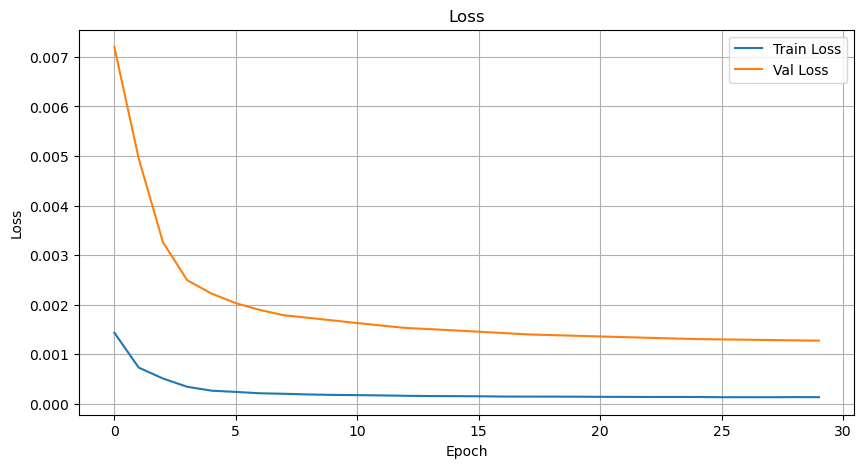

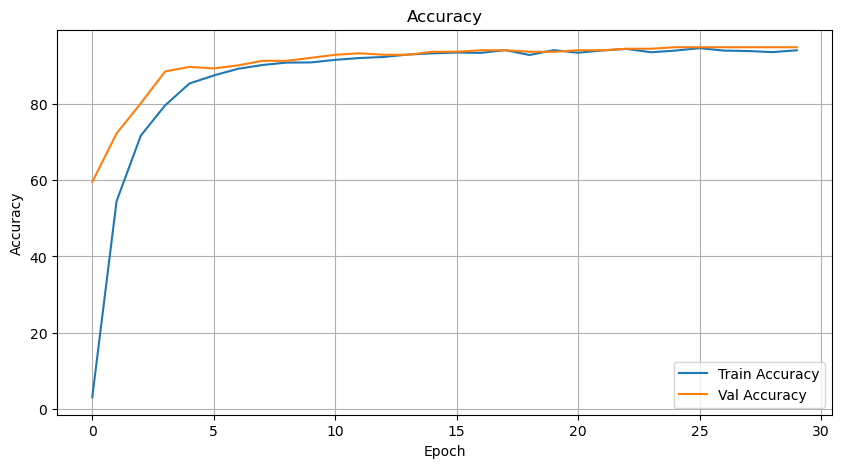

In [64]:
from matplotlib import pyplot as plt
# Loss 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(train_loss_acc[0], label='Train Loss')
plt.plot(val_loss_acc[0], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid()
plt.legend()
plt.show()

# Accuracy 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(train_loss_acc[1], label='Train Accuracy')
plt.plot(val_loss_acc[1], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid()
plt.show()

# test data predict

In [65]:
def predict(model, val_loader):
    model.eval()
    correct = 0

    with torch.no_grad():
        for image, label in val_loader:
            print(image.shape)
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            label = label.float()
            output = model(image)
    
            # print(output.max(1, keepdim = True))
            # prediction = output.round()  # 이진 분류에서는 반올림하여 0 또는 1로 변환
            prediction = output.max(1, keepdim = True)[1]
            # print(prediction)
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_accuracy = 100. * correct / len(val_loader.dataset)
    # print(prediction)
    return test_accuracy

predict(model, val_loader)

torch.Size([252, 3, 100, 100])


94.84126984126983

In [66]:
# torch.save(model.state_dict(), 'hand_model.pth')

In [80]:
# 테스트 
from torchvision.datasets import ImageFolder
from PIL import Image

# image = Image.open('screen_shot.png')
image = Image.open('test.png').convert('RGB')

# 전처리 단계 정의
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
preprocessing = transforms.Compose([
    transforms.Resize((100, 100), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# 이미지 전처리 적용
processed_image = preprocessing(image)
processed_image = processed_image.unsqueeze(0)
print(processed_image.shape)

output = model(processed_image)
prediction = output.max(1, keepdim = True)[1] 
print(prediction.item())

torch.Size([1, 3, 100, 100])
31
